# CMEPHY MCO

### Authors
- Isaac A. Dicayanan
- Alliyah Bianca Maunahan
- Nash Luis Maramag

### Date: July 9, 2025

## Libraries

In [ ]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# geospatial libraries
import geopandas as gpd

# these are not pre-installed in colab
try:
    import rasterio
    from rasterio.plot import show, show_hist
    from rasterio.mask import mask
except ImportError:
    !pip install rasterio
    import rasterio
    from rasterio.mask import mask
    from rasterio.plot import show, show_hist


In [ ]:
# configurations
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_columns', None)

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Overview

This paper uses the dataset [*Geospatial environmental and socioeconomic data*](https://www.kaggle.com/datasets/cathetorres/geospatial-environmental-and-socioeconomic-data), which is a geospatial dataset composed of 13 separate folders, each containing vector or raster data related to key environmental and socioeconomic indicators. These include population and GDP estimates, infrastructure, land use, deforestation, energy, climate variables, and livestock distribution. The data contains point and polygon `.shp` files, as well as raster data (`.tif`), and the data comes from publicly accessible sources.

While a detailed description of all the folders is available on the official dataset page, brief summaries are included below to provide context and aid understanding within this notebook.

### Folder Descriptions

1. **Cities and Towns**: Contains global populated places, including major cities, towns, and admin-level capitals (~7,000 locations). Attributes include names in multiple languages, scale ranks, and LandScan-derived population estimates.

2. **Roads and Railroads**: Includes major road and railway networks across North America. Attributes cover route type, class, and number.

3. **Airports and Ports**: Global coverage of ports and airports. Includes key infrastructure attributes for transport hubs such as location, size, and role.

4. **Global Power Plant Database**: Global geolocated database of ~30,000 power plants across 164 countries. Includes plant type (thermal or renewable), generation capacity, fuel source, and ownership.

5. **Gridded Population 2015 (250 m)**: Population grid for 2015 created by re-mapping census data using built-up area information. Values represent people per cell.

6. **Gridded GDP and HDI (1990–2015)**: Annual global grids for GDP per capita, total GDP, and Human Development Index. Includes subnational and national-level data, plus quality indicators.

7. **Gridded Land Cover 2015**: ESA CCI global land cover classification at 300 m resolution. Each cell is assigned a land cover class based on the UN Land Cover Classification System (22 classes total).

8. **Tree Cover Loss by Dominant Driver**: Identifies the dominant driver of forest loss from 2001–2019 for each 10 km grid cell. Categories include commodity-driven deforestation, shifting agriculture, wildfire, urbanization, and forestry.

9. **Carbon Accumulation Potential (Reforestation)**: Estimates the potential rate of carbon accumulation over 30 years in reforestable areas.

10. **Solar Energy Potential**: Three layers showing: (1) Global Horizontal Irradiance (GHI), (2) Irradiation for optimally tilted surfaces (GTI), and (3) Photovoltaic output (PVOUT).

11. **Air Temperature**: Global gridded dataset of air temperature at 2 m above ground, with 1 km resolution.

12. **Global Cattle Distribution 2010**: Livestock density grid showing number of cattle per pixel.

## Research Question

For this project, the question we aim to answer is


> **What is the carbon accumulation potential in areas surrounding urban settlements, and how does this intersect with past forest loss?**

This project investigates the spatial overlap between areas of forest loss (specifically loss driven by urbanization) and the potential for carbon recovery. The goal is to identify priority regions near urban areas in the Philippines where reforestation efforts would be most beneficial for carbon sequestration.

### Dataset Folders Used

This analysis utilizes only a subset of the full geospatial dataset, specifically those that provide information about urban centers, forest loss, and ecological recovery potential. The following folders are included:

1. Cities and Towns

This folder contains two spatial layers: one with point locations of populated places and another with polygons representing urban extents. They provide the basis for identifying urban settlements and their surrounding ares in the Philippines.

2. Tree Cover Loss by Dominant Driver

This folder contains a raster file that categorizes areas of forest loss from 2001-2019 by their dominant driver. For this project we want to identify deforestation near settlements, which is a key factor in determining carbon recovery potential in the surrounding landscape.

3. Carbon Accumulation Potential

This folder contains a single raster file estimating the rate at which carbon could be sequestered through natural forest regrowth. The data represents carbon accumulation potential over a 30-year period and will be used to assess the recovery capacity of areas surrounding urban settlements that have experienced forest loss.

## Data Understanding and Preprocessing

All datasets are stored in a structured directory within Google Drive and accessed using absolute paths. The absolute paths are lengthy so let us first store the paths in variables to ensure the notebook remains readable throughout the project.

In [ ]:
POPULATED_PLACES_PATH =       r'/content/drive/MyDrive/CMEPHY/Data/1_CITIES_landscan/ne_10m_populated_places/ne_10m_populated_places.shp'
URBAN_AREAS_PATH =            r'/content/drive/MyDrive/CMEPHY/Data/1_CITIES_landscan/ne_10m_urban_areas_landscan/ne_10m_urban_areas_landscan.shp'
DEFORESTATION_PATH =          r'/content/drive/MyDrive/CMEPHY/Data/8_GFW_deforestation/Goode_FinalClassification_19_05pcnt_prj/Goode_FinalClassification_19_05pcnt_prj.tif'
CARBON_SEQUESTRATION_PATH =   r'/content/drive/MyDrive/CMEPHY/Data/9_GFW_potential_carbon_sequestration/young_forest_sequestration_rate_Griscom_extent.tif'

### Populated Places

Let us first load the shapefile in `gdf_pop_places`.

In [ ]:
gdf_pop_places = gpd.read_file(POPULATED_PLACES_PATH)
gdf_pop_places.head()

,SCALERANK,NATSCALE,LABELRANK,FEATURECLA,NAME,NAMEPAR,NAMEALT,DIFFASCII,NAMEASCII,ADM0CAP,CAPIN,WORLDCITY,MEGACITY,SOV0NAME,SOV_A3,ADM0NAME,ADM0_A3,ADM1NAME,ISO_A2,NOTE,LATITUDE,LONGITUDE,CHANGED,NAMEDIFF,DIFFNOTE,POP_MAX,POP_MIN,POP_OTHER,RANK_MAX,RANK_MIN,GEONAMEID,MEGANAME,LS_NAME,LS_MATCH,CHECKME,MAX_POP10,MAX_POP20,MAX_POP50,MAX_POP300,MAX_POP310,MAX_NATSCA,MIN_AREAKM,MAX_AREAKM,MIN_AREAMI,MAX_AREAMI,MIN_PERKM,MAX_PERKM,MIN_PERMI,MAX_PERMI,MIN_BBXMIN,MAX_BBXMIN,MIN_BBXMAX,MAX_BBXMAX,MIN_BBYMIN,MAX_BBYMIN,MIN_BBYMAX,MAX_BBYMAX,MEAN_BBXC,MEAN_BBYC,COMPARE,GN_ASCII,FEATURE_CL,FEATURE_CO,ADMIN1_COD,GN_POP,ELEVATION,GTOPO30,TIMEZONE,GEONAMESNO,UN_FID,UN_ADM0,UN_LAT,UN_LONG,POP1950,POP1955,POP1960,POP1965,POP1970,POP1975,POP1980,POP1985,POP1990,POP1995,POP2000,POP2005,POP2010,POP2015,POP2020,POP2025,POP2050,CITYALT,min_zoom,wikidataid,wof_id,CAPALT,name_en,name_de,name_es,name_fr,name_pt,name_ru,name_zh,label,name_ar,name_bn,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_sv,name_tr,name_vi,wdid_score,ne_id,geometry
0,10,1,8,Admin-1 capital,Colonia del Sacramento,None,None,0,Colonia del Sacramento,0.0,None,0.0,0,Uruguay,URY,Uruguay,URY,Colonia,UY,None,-34.479999,-57.840002,4.0,1,Added missing admin-1 capital. Population from...,21714,21714,0,7,7,3443013.0,None,None,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Colonia del Sacramento,P,PPL,4.0,21714.0,0.0,28.0,America/Montevideo,Geonames ascii name + lat.d + long.d matching.,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,9.0,Q56064,421199749,0,Colonia del Sacramento,Colonia del Sacramento,Colonia del Sacramento,Colonia del Sacramento,Colónia do Sacramento,Колония-дель-Сакраменто,科洛尼亞德爾薩克拉門托,None,None,কোলোনিয়া দেল সাক্রামেন্তো,Κολόνια ντελ Σακραμέντο,None,Colonia del Sacramento,None,Colonia del Sacramento,コロニア・デル・サクラメント,콜로니아델사크라멘토,Colonia del Sacramento,Colonia del Sacramento,Colonia del Sacramento,Colonia del Sacramento,Colonia del Sacramento,4,1159112629,POINT (-57.84 -34.48)
1,10,1,8,Admin-1 capital,Trinidad,None,None,0,Trinidad,0.0,None,0.0,0,Uruguay,URY,Uruguay,URY,Flores,UY,None,-33.543999,-56.900997,4.0,1,Added missing admin-1 capital. Population from...,21093,21093,0,7,7,3439749.0,None,None,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Trinidad,P,PPL,6.0,21093.0,0.0,134.0,America/Montevideo,Geonames ascii name + lat.d + long.d matching.,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,9.0,Q862508,890444639,0,Trinidad,Trinidad,Trinidad,Trinidad,Trinidad,Тринидад,特立尼達,None,ترينيداد، أوروغواي,ত্রিনিদাদ,Τρινιντάντ,त्रिनिडाड,None,Trinidad,Trinidad,トリニダ,트리니다드,Trinidad,Trinidad,Trinidad,Trinidad,Trinidad,4,1159112647,POINT (-56.901 -33.544)
2,10,1,8,Admin-1 capital,Fray Bentos,None,None,0,Fray Bentos,0.0,None,0.0,0,Uruguay,URY,Uruguay,URY,Río Negro,UY,None,-33.138999,-58.303997,4.0,1,Added missing admin-1 capital. Population from...,23279,23279,0,7,7,3442568.0,None,None,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Fray Bentos,P,PPL,12.0,23279.0,0.0,43.0,America/Montevideo,Geonames ascii name + lat.d + long.d matching.,0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,9.0,Q849835,890451703,0,Fray Bentos,Fray Bentos,Fray Bentos,Fray Bentos,Fray Bentos,Фрай-Бентос,弗賴本托斯,None,فراي بنتوس,ফ্রায় বেন্তোস,Φρέι Μπέντος,फ्राई बैन्टोस,None,Fray Bentos,Fray Bentos,フライ・ベントス,프라이벤토스,Fray Bentos,Fray Bentos,Fray Bentos,Fray Bentos,Fray Bentos,4,1159112663,POINT (-58.304 -33.139)
3,10,1,8,Admin-1 capital,Canelones,None,None,0,Canelones,0.0,None,0.0,0,Uruguay,URY,Uruguay,URY,Canelones,UY,None,-34.538004,-56.284001,4.0,1,Added missing admin-1 capital. Population from...,19698,19698,0,6,6,3443413.0,None,None,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(gdf_pop_places.columns)
print(len(gdf_pop_places))

Index(['SCALERANK', 'NATSCALE', 'LABELRANK', 'FEATURECLA', 'NAME', 'NAMEPAR',
       'NAMEALT', 'DIFFASCII', 'NAMEASCII', 'ADM0CAP', 'CAPIN', 'WORLDCITY',
       'MEGACITY', 'SOV0NAME', 'SOV_A3', 'ADM0NAME', 'ADM0_A3', 'ADM1NAME',
       'ISO_A2', 'NOTE', 'LATITUDE', 'LONGITUDE', 'CHANGED', 'NAMEDIFF',
       'DIFFNOTE', 'POP_MAX', 'POP_MIN', 'POP_OTHER', 'RANK_MAX', 'RANK_MIN',
       'GEONAMEID', 'MEGANAME', 'LS_NAME', 'LS_MATCH', 'CHECKME', 'MAX_POP10',
       'MAX_POP20', 'MAX_POP50', 'MAX_POP300', 'MAX_POP310', 'MAX_NATSCA',
       'MIN_AREAKM', 'MAX_AREAKM', 'MIN_AREAMI', 'MAX_AREAMI', 'MIN_PERKM',
       'MAX_PERKM', 'MIN_PERMI', 'MAX_PERMI', 'MIN_BBXMIN', 'MAX_BBXMIN',
       'MIN_BBXMAX', 'MAX_BBXMAX', 'MIN_BBYMIN', 'MAX_BBYMIN', 'MIN_BBYMAX',
       'MAX_BBYMAX', 'MEAN_BBXC', 'MEAN_BBYC', 'COMPARE', 'GN_ASCII',
       'FEATURE_CL', 'FEATURE_CO', 'ADMIN1_COD', 'GN_POP', 'ELEVATION',
       'GTOPO30', 'TIMEZONE', 'GEONAMESNO', 'UN_FID', 'UN_ADM0', 'UN_LAT',
       'UN_LONG', 'P

We can observe that the data contains a lot of columns and has 7343 records. The relevant columns for this study are the ones below:

| Column Name             | Description                                      |
| ----------------------- | -------------------------------------------------|
| `NAME`                  | Common name of the city or town                  |
| `ADM0NAME`              | Country name                                     |
| `ADM1NAME`              | First-level administrative division (e.g., province or region)                                                                   |
| `POP_MAX`               | Maximum estimated population                     |
| `LATITUDE`, `LONGITUDE` | Coordinates of the place (redundant with geometry  but useful for inspection)                                                   |
| `geometry`              | Spatial data                                     |

The other columns include translations of the other columns (`name_es`, `name_fr`, etc.), population data (`POP1950` to `POP2050`) and metadata (`GEONAMEID`, `SCALERANK`, etc). These columns are not relevant for our analysis so we dropped these columns.




In [ ]:
columns_to_include = ['NAME', 'ADM0NAME', 'ADM1NAME', 'POP_MAX', 'LATITUDE', 'LONGITUDE', 'geometry']

gdf_pop_places = gdf_pop_places[columns_to_include]
gdf_pop_places.head()

,NAME,ADM0NAME,ADM1NAME,POP_MAX,LATITUDE,LONGITUDE,geometry
0,Colonia del Sacramento,Uruguay,Colonia,21714,-34.479999,-57.840002,POINT (-57.84 -34.48)
1,Trinidad,Uruguay,Flores,21093,-33.543999,-56.900997,POINT (-56.901 -33.544)
2,Fray Bentos,Uruguay,Río Negro,23279,-33.138999,-58.303997,POINT (-58.304 -33.139)
3,Canelones,Uruguay,Canelones,19698,-34.538004,-56.284001,POINT (-56.284 -34.538)
4,Florida,Uruguay,Florida,32234,-34.099002,-56.214998,POINT (-56.215 -34.099)


Let us check if these columns have missing values and if they have duplicated rows.

In [ ]:
gdf_pop_places.isnull().sum()

,0
NAME,0
ADM0NAME,0
ADM1NAME,119
POP_MAX,0
LATITUDE,0
LONGITUDE,0
geometry,0


All the missing values are from the `ADM1NAME` column. Since this column is only the province/region of the city and only 1% of the column is missing, ignoring the missing values will not affect our analysis.

From calling the `.head()` method we observe that the `geometry` column consists of point geometries. Let us verify that each row in `gdf_pop_places` represents a point geometry

In [ ]:
print(gdf_pop_places.geom_type.unique())

['Point']


We now filter entries that are located within the Philippines

In [ ]:
gdf_pop_places = gdf_pop_places[gdf_pop_places["ADM0NAME"] == "Philippines"]
print(gdf_pop_places.head())
print("Number of entries after filtering: ", len(gdf_pop_places))

            NAME     ADM0NAME            ADM1NAME  POP_MAX   LATITUDE  \
3022  San Carlos  Philippines   Negros Occidental     6353  10.550375   
3023       Cadiz  Philippines   Negros Occidental   283157  10.958748   
3024    Pagadian  Philippines   Zamboanga Del Sur   159590   7.852969   
3025      Ozamis  Philippines  Misamis Occidental    97806   8.146207   
3026      Tarlac  Philippines              Tarlac   183930  15.483795   

       LONGITUDE                    geometry  
3022  123.380004     POINT (123.38 10.55038)  
3023  123.308587  POINT (123.30859 10.95875)  
3024  123.507024   POINT (123.50702 7.85297)  
3025  123.844420   POINT (123.84442 8.14621)  
3026  120.583378   POINT (120.58338 15.4838)  
Number of entries after filtering:  38


In [ ]:
gdf_pop_places.isnull().sum()

,0
NAME,0
ADM0NAME,0
ADM1NAME,0
POP_MAX,0
LATITUDE,0
LONGITUDE,0
geometry,0


After filtering only for cities in the Philippines, we are left with **38** entries and there are no null values. Let us now see the spatial distribution visually

<Axes: >

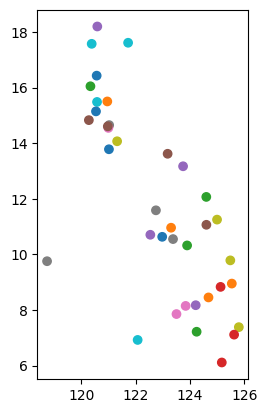

In [ ]:
gdf_pop_places.plot("NAME")

Each point in this plot represents a city in the Philippines.

### Urban Areas

Let us load the data in `gdf_urban`

In [ ]:
gdf_urban = gpd.read_file(URBAN_AREAS_PATH)
gdf_urban.head()

,name_conve,max_pop_al,max_pop_20,max_pop_50,max_pop_30,max_pop_31,max_natsca,min_areakm,max_areakm,min_areami,max_areami,min_perkm,max_perkm,min_permi,max_permi,min_bb_xmi,max_bb_xmi,min_bb_xma,max_bb_xma,min_bb_ymi,max_bb_ymi,min_bb_yma,max_bb_yma,mean_bb_xc,mean_bb_yc,geometry
0,Aalborg,101616.0,101616.0,0.0,0.0,0.0,20.0,76.0,76.0,29.0,29.0,84.0,84.0,52.0,52.0,9.850000,9.850000,10.033333,10.033333,56.983333,56.983333,57.100000,57.100000,9.933411,57.036154,"POLYGON ((9.98333 57.09167, 9.98333 57.08333, ..."
1,Aarhus,227100.0,227100.0,0.0,0.0,0.0,20.0,131.0,131.0,51.0,51.0,135.0,135.0,84.0,84.0,10.058333,10.058333,10.350000,10.350000,56.083333,56.083333,56.266667,56.266667,10.180266,56.165522,"POLYGON ((10.325 56.23333, 10.325 56.225, 10.3..."
2,Aba,851210.0,851210.0,0.0,0.0,0.0,20.0,278.0,278.0,108.0,108.0,303.0,303.0,188.0,188.0,7.233333,7.233333,7.425000,7.425000,4.883333,4.883333,5.241667,5.241667,7.338774,5.084213,"POLYGON ((7.36667 5.05833, 7.36667 5.05, 7.366..."
3,Abadan,260078.0,260078.0,0.0,0.0,0.0,20.0,44.0,44.0,17.0,17.0,59.0,59.0,37.0,37.0,48.233333,48.233333,48.333333,48.333333,30.308333,30.308333,30.391667,30.391667,48.278750,30.341528,"POLYGON ((48.25 30.35833, 48.25833 30.35833, 4..."
4,Abaetetuba,79420.0,79420.0,0.0,0.0,0.0,20.0,10.0,10.0,4.0,4.0,15.0,15.0,9.0,9.0,-48.891667,-48.891667,-48.858333,-48.858333,-1.741667,-1.741667,-1.708333,-1.708333,-48.877083,-1.722917,"POLYGON ((-48.86667 -1.70833, -48.86667 -1.716..."


In [ ]:
print(gdf_urban.columns)
print(len(gdf_urban))

Index(['name_conve', 'max_pop_al', 'max_pop_20', 'max_pop_50', 'max_pop_30',
       'max_pop_31', 'max_natsca', 'min_areakm', 'max_areakm', 'min_areami',
       'max_areami', 'min_perkm', 'max_perkm', 'min_permi', 'max_permi',
       'min_bb_xmi', 'max_bb_xmi', 'min_bb_xma', 'max_bb_xma', 'min_bb_ymi',
       'max_bb_ymi', 'min_bb_yma', 'max_bb_yma', 'mean_bb_xc', 'mean_bb_yc',
       'geometry'],
      dtype='object')
6018


We can observe that the Urban Areas data has **6018** records and a wide range of columns. We will only keep the following columns:

| Column Name  |Description                                             |
| ------------ |------------------------------------------------------- |
| `name_conve` | name of the urban area                                 |
| `max_pop_al` | Total estimated population for the urban area          |
| `max_areakm` | Maximum estimated area in square kilometers            |
| `geometry`   | Spatial data                                           |

The other columns are population and area estimates (`max_pop_20`, `max_areami`) which we drop since these are already covered by the selected columns. Similarly, the bounding box statistics (`bb` related columns) are also dropped, because this information is already in `geometry`.


In [ ]:
columns_to_include = ['name_conve', 'max_pop_al', 'max_areakm', 'geometry']

gdf_urban = gdf_urban[columns_to_include]
gdf_urban.head()

,name_conve,max_pop_al,max_areakm,geometry
0,Aalborg,101616.0,76.0,"POLYGON ((9.98333 57.09167, 9.98333 57.08333, ..."
1,Aarhus,227100.0,131.0,"POLYGON ((10.325 56.23333, 10.325 56.225, 10.3..."
2,Aba,851210.0,278.0,"POLYGON ((7.36667 5.05833, 7.36667 5.05, 7.366..."
3,Abadan,260078.0,44.0,"POLYGON ((48.25 30.35833, 48.25833 30.35833, 4..."
4,Abaetetuba,79420.0,10.0,"POLYGON ((-48.86667 -1.70833, -48.86667 -1.716..."


Let us verify the spatial object of each row



In [ ]:
gdf_urban.geom_type.value_counts()


,count
Polygon,5910
MultiPolygon,108


We can observe that we have records for both `Polygon` and `MultiPolygon` in the data.

Since `gdf_urban` does not include country attributes, we need to perform a spatial join with `gdf_pop_places`, which contains a column for the country (`ADM0NAME`)

In [ ]:
gdf_urban = gpd.sjoin(gdf_urban, gdf_pop_places,
                      predicate="intersects",
                      how="inner")

gdf_urban = gdf_urban.drop(columns=["index_right"]).reset_index(drop=True)
gdf_urban.head()

,name_conve,max_pop_al,max_areakm,geometry,NAME,ADM0NAME,ADM1NAME,POP_MAX,LATITUDE,LONGITUDE
0,Bacolod,949354.0,327.0,"POLYGON ((123.04167 10.85, 123.05 10.85, 123.0...",Bacolod,Philippines,Negros Occidental,949354,10.631688,122.981682
1,Batangas,424508.0,88.0,"POLYGON ((121.05 13.79167, 121.05 13.78333, 12...",Batangas,Philippines,Batangas,424508,13.781677,121.021698
2,Butuan,190557.0,41.0,"POLYGON ((125.6 8.96667, 125.60833 8.96667, 12...",Butuan,Philippines,Agusan del Norte,190557,8.949543,125.543592
3,Cabanatuan,1675550.0,2014.0,"POLYGON ((120.90833 15.875, 120.9 15.875, 120....",Cabanatuan,Philippines,Nueva Ecija,220250,15.502089,120.961702
4,Calbayog,42109.0,14.0,"POLYGON ((124.60833 12.08333, 124.60833 12.075...",Calbayog,Philippines,Samar,67921,12.067182,124.604167


In [ ]:
len(gdf_urban)

34

After performing a spatial join between the *populated places* (points) and the *urban areas* (polygons), we observed that 11 out of 38 cities were not matched. This means these city points do not spatially intersect with any urban polygon in the dataset. We will drop these unmatched cities from `gdf_pop_places`.


In [ ]:
unmatched = gdf_pop_places[~gdf_pop_places['NAME'].isin(gdf_urban['NAME'])]
print(unmatched['NAME'])

gdf_pop_places = gdf_pop_places[gdf_pop_places['NAME'].isin(gdf_urban['NAME'])]
print("Remaining Entries after dropping unmatched cities: ", len(gdf_pop_places))

3022        San Carlos
3023             Cadiz
3033            Iligan
3035          Tacloban
3039           Gingoog
5054           Legazpi
5055        Tuguegarao
5056             Vigan
5757           Angeles
5761    Cagayan de Oro
6389       Baguio City
Name: NAME, dtype: object
Remaining Entries after dropping unmatched cities:  27


Some urban polygons contain more than one city point. This occurs in cases where several neighboring cities are part of a larger urbanized region. These overlapping cases are valid and expected. We do not drop these repeated polygons, because even if the polygon is shared, the cities within it have different attributes such as population or administrative identity.

In [ ]:
urban_duplicates = gdf_urban['geometry'].value_counts()

print(f"Total urban records after join: {len(gdf_urban)}")
print(f"Unique urban geometries: {gdf_urban['geometry'].nunique()}")


Total urban records after join: 34
Unique urban geometries: 27


Let us also visualize the urban boundaries alongside the point locations of populated places.

<Axes: >

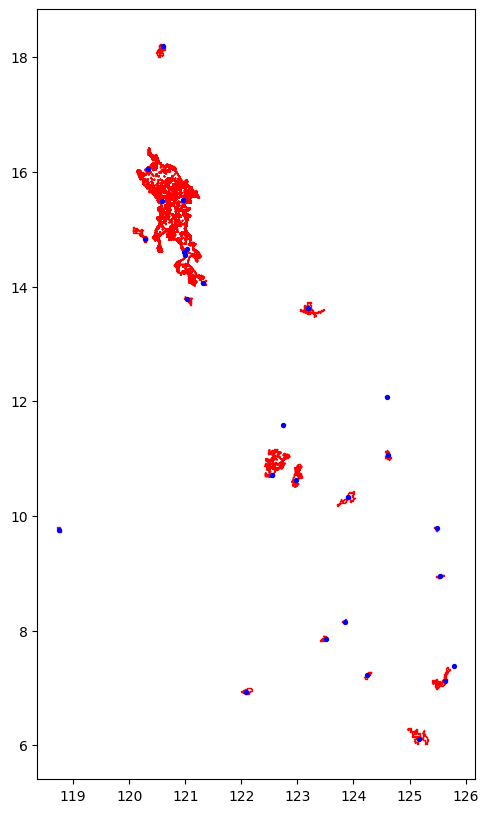

In [ ]:
ax = gdf_urban.plot(edgecolor='red', facecolor='none', figsize=(10, 10))
gdf_pop_places.plot(ax=ax, color='blue', markersize=8)


This plot helps shows that each city point falls within or near its respective urban boundary.

### Tree Cover Loss

Let us load the Tree Cover Loss raster data in the variable `raster_tree` and display its metadata

In [ ]:
raster_tree = rasterio.open(DEFORESTATION_PATH)

In [ ]:
print("CRS:", raster_tree.crs)
print("Bounds:", raster_tree.bounds)
print("Resolution:", raster_tree.res)
print("NoData value:", raster_tree.nodata)
print("Shape:", raster_tree.shape)

CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99998404921843, bottom=-90.08338275296424, right=180.03231004323806, top=89.49922259580185)
Resolution: (0.09634259943603331, 0.09634259943603331)
NoData value: -1.7e+308
Shape: (1864, 3737)


Let us plot `raster_tree`

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


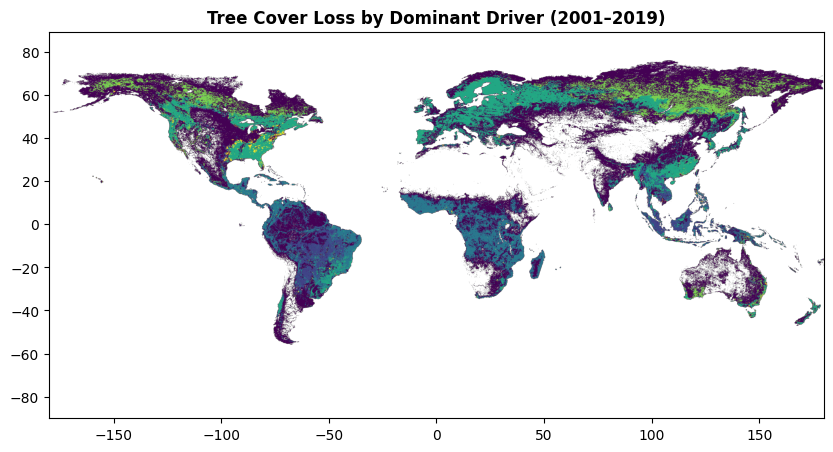

<Axes: title={'center': 'Tree Cover Loss by Dominant Driver (2001–2019)'}>

In [ ]:
plt.figure(figsize=(10, 10))
show(raster_tree, title="Tree Cover Loss by Dominant Driver (2001–2019)")

The different colors for the areas represent the dominant driver of Tree Cover Loss. These values range from 1-5 as seen in the unique values of the raster below:

In [ ]:
data = raster_tree.read(1)
unique_values = np.unique(data[data != raster_tree.nodata])

print("Unique values:", unique_values)

Unique values: [0. 1. 2. 3. 4. 5.]


The documentation does not specify which value represents which category but it is most likely in order of how they documented it. The value `0` often represents none, in this case no forest loss detected.

| Value | Category                               |
| ----- | -------------------------------------- |
| 1     | Commodity-driven deforestation         |
| 2     | Shifting agriculture                   |
| 3     | Forestry                               |
| 4     | Wildfire                               |
| 5     | Urbanization                           |
| 0     | No forest loss                         |


Since we are only interested in urban areas in the Philippines, we need to clip the raster using the polygons of urban areas.

In [ ]:
gdf_urban_raster_crs = gdf_urban.to_crs(raster_tree.crs)

urban_geom = [feature["geometry"] for feature in gdf_urban_raster_crs.__geo_interface__["features"]]
tree_clipped, tree_transform = mask(raster_tree, urban_geom, crop=True)



We can now mask out values with no data
for a clean visualization of the urban areas. The clipped forest loss raster will be stored in the `tree_array` variable

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


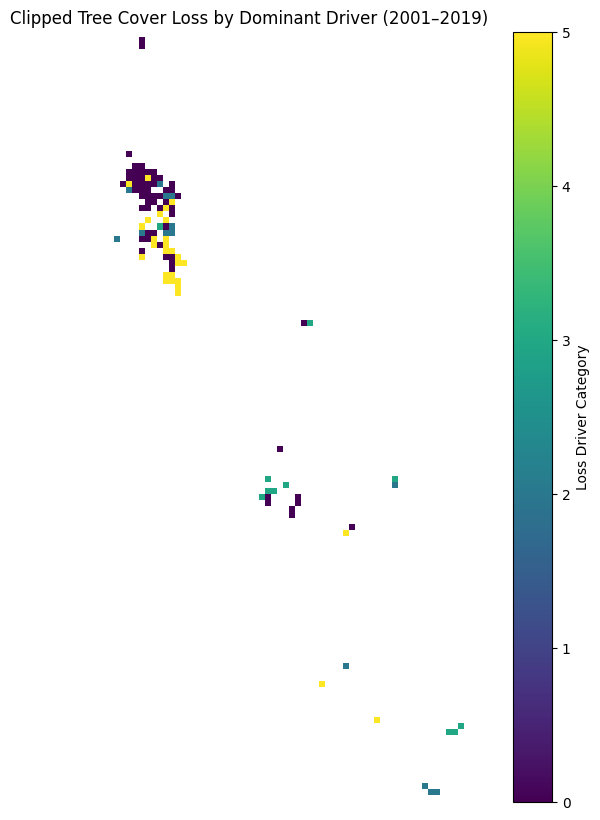

In [ ]:
tree_array = tree_clipped[0]

tree_array = np.ma.masked_equal(tree_array, raster_tree.nodata)

plt.figure(figsize=(10, 10))
plt.imshow(tree_array)
plt.colorbar(label="Loss Driver Category")
plt.title("Clipped Tree Cover Loss by Dominant Driver (2001–2019)")
plt.axis('off')
plt.show()


### Carbon Sequestration

Let us load the Carbon Sequestration raster data in the variable `raster_carbon` and display its metadata

In [ ]:
raster_carbon = rasterio.open(CARBON_SEQUESTRATION_PATH)

In [ ]:
print("CRS:", raster_carbon.crs)
print("Bounds:", raster_carbon.bounds)
print("Resolution:", raster_carbon.res)
print("NoData value:", raster_carbon.nodata)
print("Shape:", raster_carbon.shape)

CRS: ESRI:54034
Bounds: BoundingBox(left=-20037507.842788246, bottom=-6363854.791091753, right=20037682.312660877, top=6363884.831926044)
Resolution: (739.340088470392, 739.340088470392)
NoData value: nan
Shape: (17215, 54204)


Let us visualize `raster_carbon`. Since this raster data is extremely large, plotting the full resolution causes memory issues in colab and crashes the session. For this visualization we downsampled every 50 pixel to have a low res preview of the data

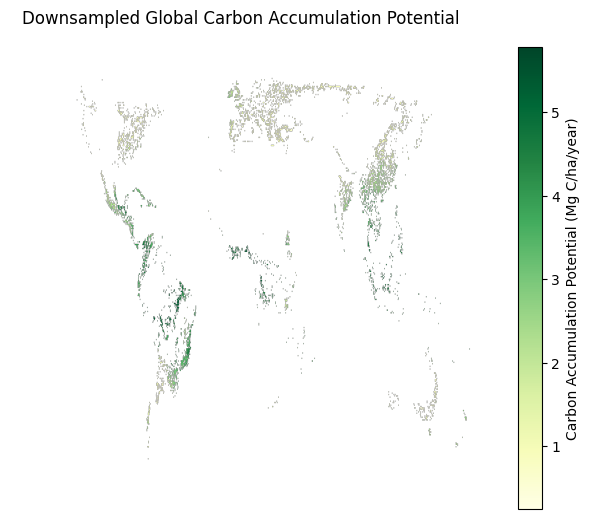

In [ ]:
step = 50

carbon_array_preview = raster_carbon.read(1)[::step, ::step]
carbon_array_preview = np.ma.masked_equal(carbon_array_preview, raster_carbon.nodata)

plt.figure(figsize=(12, 6))
plt.imshow(carbon_array_preview, cmap='YlGn', extent=raster_carbon.bounds)
plt.colorbar(label="Carbon Accumulation Potential (Mg C/ha/year)")
plt.title("Downsampled Global Carbon Accumulation Potential")
plt.axis('off')
plt.show()

We also clipped `raster_carbon` using the polygons in `gdf_urban`. The documentation of the Carbon Sequestration data mentioned that the data mainly revolves around forests. Since `gdf_urban` consists of polygons for cities, we created a buffer around each polygon to analyze the areas around urban regions.  

In [ ]:
# Reproject `gdf_urban` to match raster_carbon since the CRS of the raster is different
gdf_urban_carbon_crs = gdf_urban.to_crs(raster_carbon.crs)

urban_union = gdf_urban_carbon_crs.union_all()
urban_buffered = urban_union.buffer(10000)

carbon_masked_all, carbon_transform_all = mask(raster_carbon, [urban_buffered], crop=True)



the clipped carbon accumulation raster will be stored in the `carbon_array_all` variable

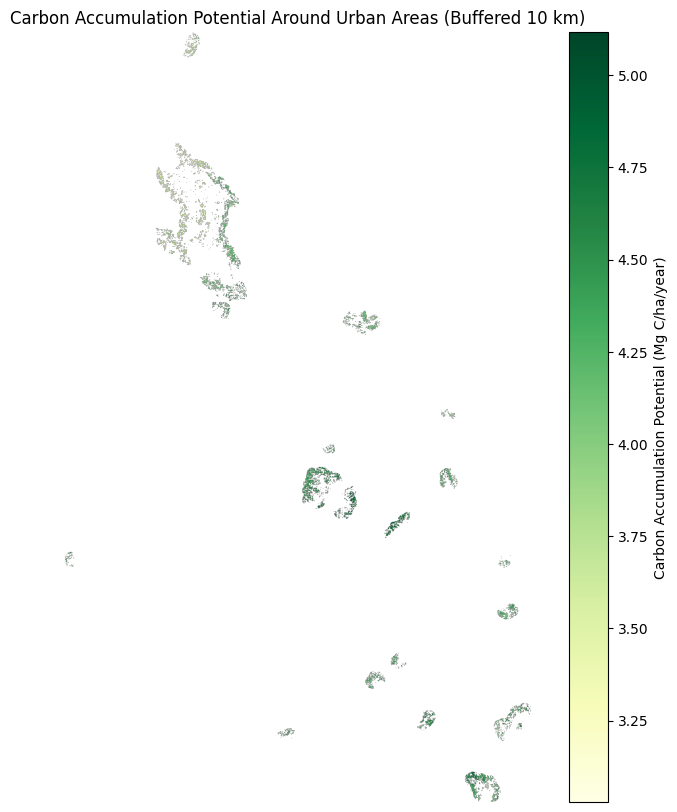

In [ ]:
carbon_array_all = carbon_masked_all[0]
carbon_array_all = np.ma.masked_invalid(carbon_array_all)

plt.figure(figsize=(10, 10))
plt.imshow(carbon_array_all, cmap='YlGn')
plt.colorbar(label="Carbon Accumulation Potential (Mg C/ha/year)")
plt.title("Carbon Accumulation Potential Around Urban Areas (Buffered 10 km)")
plt.axis('off')
plt.show()

This plot shows the carbon accumulation potential around the urban areas in `gdf_urban`

## Exploratory Data Analysis

This section aims to gain a deeper understanding of the spatial and raster data used in the study by performing basic statistical and visual analyses. Since our research question focuses on the relationship between tree cover loss (`tree_array`) and carbon accumulation potential (`carbon_array_all`) in areas surrounding urban settlements (`gdf_pop_places` & `gdf_urban`), the EDA is centered on these variables.

### Histogram of Forest Loss Drivers

We explore the dominant drivers of forest loss clipped to urban boundaries in the Philippines. We excluded pixels with a value of 0 as it represents no classification.

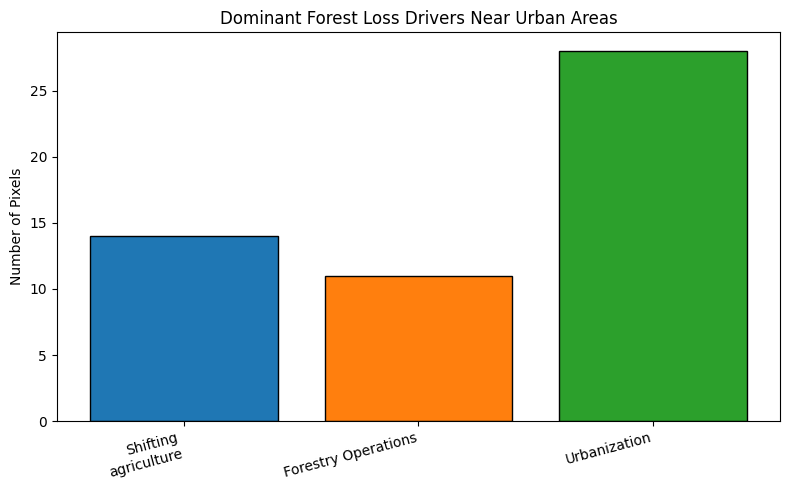

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

tree_flat = tree_array.compressed()
tree_flat = tree_flat[tree_flat != 0]

unique, counts = np.unique(tree_flat, return_counts=True)

# Map categories
driver_labels = {
    1: 'Commodity-driven\ndeforestation',
    2: 'Shifting\nagriculture',
    3: 'Forestry Operations',
    4: 'Wildfire',
    5: 'Urbanization'
}

labels = [driver_labels.get(val, f"Unknown ({val})") for val in unique]
colors = plt.get_cmap('tab10').colors[:len(unique)]

plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color=colors, edgecolor='black')
plt.title('Dominant Forest Loss Drivers Near Urban Areas')
plt.ylabel('Number of Pixels')
plt.xticks(rotation=15, ha='right')
plt.tight_layout(); plt.show()


We can observe that **urbanization** is the most common driver, which aligns with the data since it is clipped to urban boundaries.

### Histogram of Carbon Accumulation Potential

We analyze the distribution of carbon accumulation potential from the clipped raster data (`carbon_array_all`)

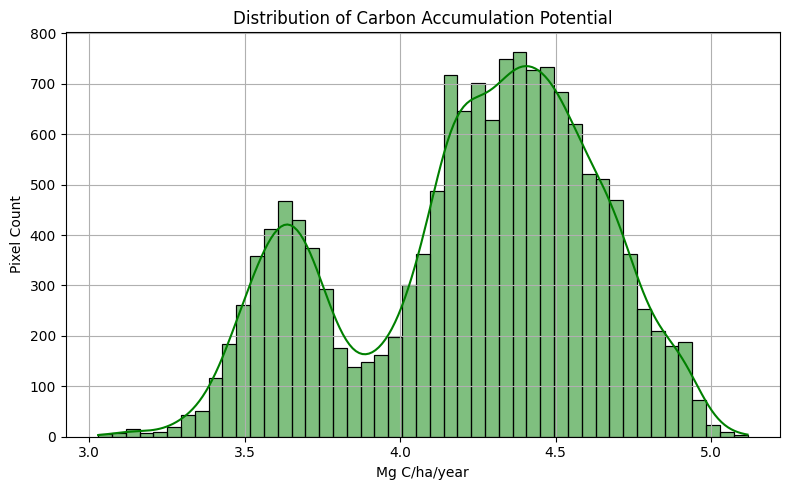

In [ ]:
carbon_flat = carbon_array_all.compressed()

plt.figure(figsize=(8, 5))
sns.histplot(carbon_flat, kde=True, color='green')
plt.title('Distribution of Carbon Accumulation Potential')
plt.xlabel('Mg C/ha/year'); plt.ylabel('Pixel Count')
plt.grid(True); plt.tight_layout(); plt.show()


For the carbon sequestration raster, the resolution is 1km x 1km which explains why the pixel count is higher compared to the tree loss raster.

The carbon values range from approximately 3.0 to 5.0 Mg C/ha/year, with most of the pixels falling between 3.5 and 4.7. This indicates a generally moderate high carbon recovery potentials in reforesting areas around urban centers.

We observe that the data peaks at two values. The value where MG C/ha/year is 3.6 has around 480 pixels and the value where MG C/ha/year is 4.4 has around 750 pixels. For now, we are not able to properly interpret these peaks as we lack context just from the carbon raster alone.

### Carbon Potential per City

To understand how carbon accumulation potential varies across urban regions in the Philippines, we extract data from the carbon raster around each city using a 10km buffer (the same buffer used in the Data Understanding section)

In [ ]:
import pandas as pd
import numpy as np
from rasterio.mask import mask

gdf_urban_carbon_crs = gdf_urban.to_crs(raster_carbon.crs)

city_data = []

# loop through each urban data
for idx, row in gdf_urban_carbon_crs.iterrows():
    city_name = row['name_conve']
    city_geom = [row['geometry'].buffer(10000)]

    try:
        # mask the carbon raster with the geometry of the current citya
        carbon_masked, _ = mask(raster_carbon, city_geom, crop=True)
        carbon_array = carbon_masked[0]

        carbon_flat = carbon_array.flatten()
        carbon_clean = carbon_flat[~np.isnan(carbon_flat)]

        if len(carbon_clean) > 0:
            city_data.append({
                'city': city_name,
                'carbon': carbon_clean.tolist()
            })
    except Exception as e:
        print(f"Skipping {city_name} due to error: {e}")

df_city_carbon = pd.DataFrame(city_data)


/tmp/ipython-input-47-1559595425.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_long, x='city', y='carbon', palette='YlGn')


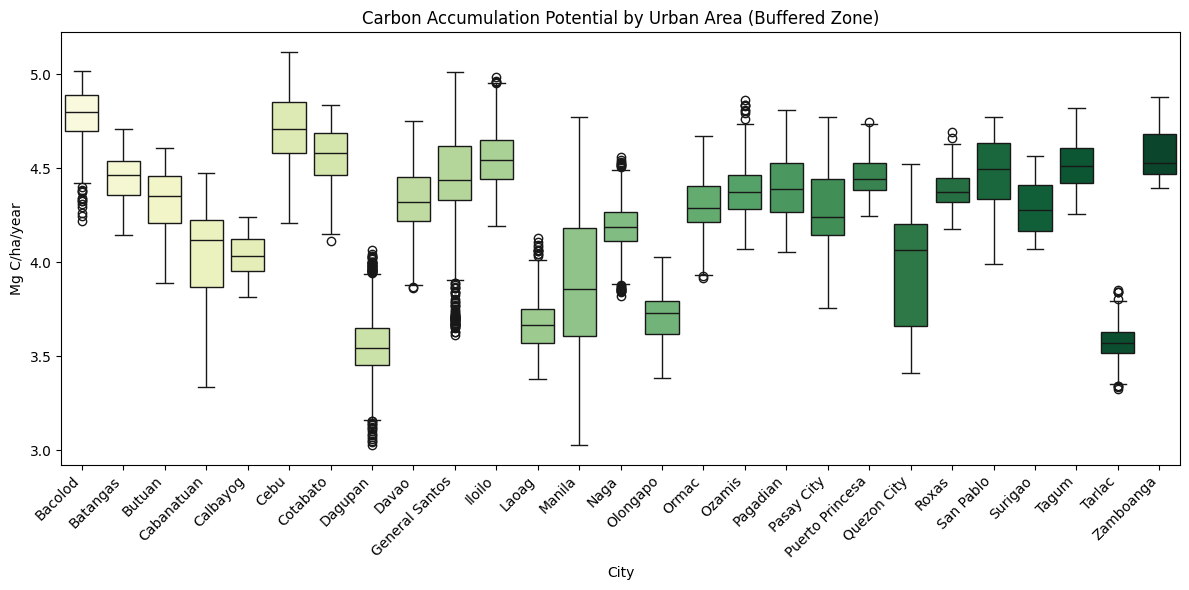

In [ ]:
df_long = df_city_carbon.explode('carbon').dropna()
df_long['carbon'] = df_long['carbon'].astype(float)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_long, x='city', y='carbon', palette='YlGn')
plt.xticks(rotation=45, ha='right')
plt.title('Carbon Accumulation Potential by Urban Area (Buffered Zone)')
plt.ylabel('Mg C/ha/year'); plt.xlabel('City')
plt.tight_layout(); plt.show()


We observe that Bacolod, Cebu, and Calbayog all exhibit a high carbon accumulation potential with medians at around 4.5 Mg C/ha/year. On the other hand, cities like Tarlac, Laoag, Ormac and Dagupan show lower medians, often below 4.0 Mg C/ha/year.

Manila and Quezon City shows high variability of Mg C/ha/year. The wide range suggests that while some zones near these cities offer high carbon potential, others are significantly lower. Lastly, outliers are observed across many cities.

### Carbon Sequestration based on Forest Loss Driver

To investigate how the cause of deforestation influences the potential for carbon accumulation, we match each pixel's forest loss driver with its corresponding carbon accumulation potential.

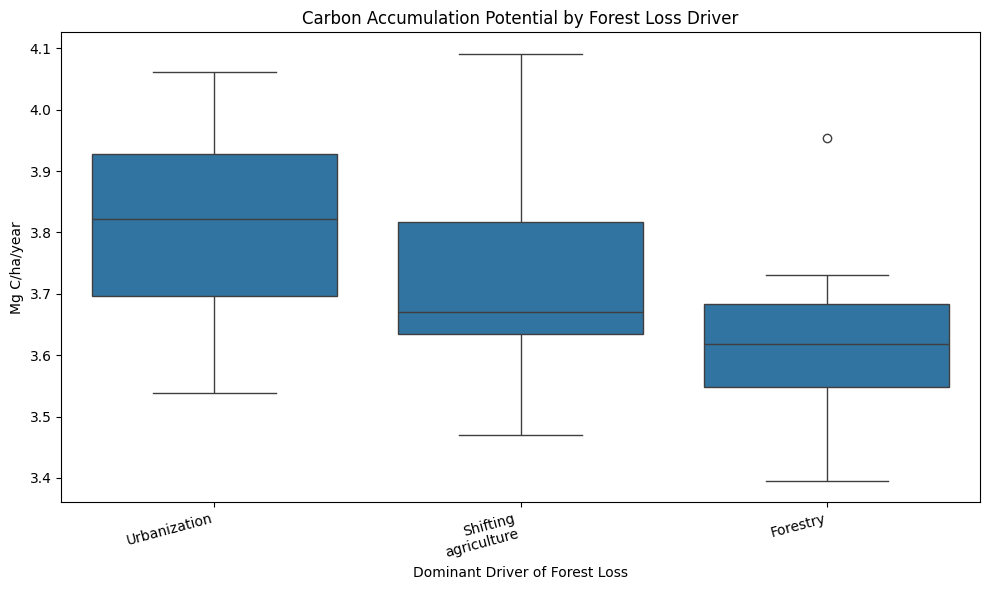

In [ ]:
tree_flat = tree_array.compressed()
carbon_flat = carbon_array_all.compressed()

min_len = min(len(tree_flat), len(carbon_flat))
tree_flat = tree_flat[:min_len]
carbon_flat = carbon_flat[:min_len]

df_combined = pd.DataFrame({
    'tree_driver': tree_flat,
    'carbon_potential': carbon_flat
})

driver_labels = {
    1: 'Commodity-driven\ndeforestation',
    2: 'Shifting\nagriculture',
    3: 'Forestry',
    4: 'Wildfire',
    5: 'Urbanization'
}

df_combined['driver_label'] = df_combined['tree_driver'].map(driver_labels)

df_plot = df_combined.dropna(subset=['carbon_potential', 'driver_label'])

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_plot, x='driver_label', y='carbon_potential')
plt.title('Carbon Accumulation Potential by Forest Loss Driver')
plt.ylabel('Mg C/ha/year')
plt.xlabel('Dominant Driver of Forest Loss'); plt.xticks(rotation=15, ha='right')
plt.tight_layout(); plt.show()


We can observe that for areas where **Urbanization** is the major tree loss driver, those areas have the highest median carbon potential with around 3.85 Mg C/ha/year. For **Shifting Agriculture**, the median is slightly lower at around 3.7 Mg C/ha/year. For these categories, the distribution is relatively wide which suggests that not all areas with the same forest loss driver are equally suitable for carbon recovery.

Lastly, **Forestry** has the lowest median carbon potential at around 3.6. For this category, the distribution is narrower, but the values cluster toward the lower end.



## Summary

The EDA highlighted key patterns in forest loss and carbon sequestration near urban areas in the Philippines. Urbanization emerged as a dominant driver of deforestation as the polygons we are working with is specifically around urban areas in the Philippines.

We observed that area affected by urban expansion tend to show relatively higher carbon accumulation potential compared to those impacted by forestry. This suggests that even with urban development spreading into natural areas, some environmental function still remains, possibly through remaining trees, green spaces on the outskirts of cities, or areas where nature is recovering near urban boundaries. On theo ther hand, areas linked to forestry show consistently lower carbon values, which may reflect more intense deforestation practices that hinder natural recovery.

There are also clear differences between cities. Places like Cebu and Iloilo display higher median carbon values, suggesting they may have more natural green spaces or have experienced less damage to their environment. On the other hand, cities like Tarlac and Dagupan appear more environmentally stressed. These differences probably come from factors like the way land has been used in the past, how well environmental laws are followed, and the natural features of these cities.

Lastly, the distribution of carbon potential show that some areas are still capable of meaningful carbon storage, while others are too damaged to recover without help. While this distinction raises questions about ecological resilience and land-use intensity of the different urban areas in the Philippines, it also points to the need for deeper investigation. These early insights serve as a foundation for a more detailed analysis in the future.

## References

1. CatheTorres. *Geospatial environmental and socioeconomic data*. https://www.kaggle.com/datasets/cathetorres/geospatial-environmental-and-socioeconomic-data